In [ ]:
!unzip data_main.zip

Archive:  data_main.zip
   creating: data_main/
   creating: data_main/293f979b-a3b4-49c1-9fca-29bcea8a9ce8/
  inflating: data_main/293f979b-a3b4-49c1-9fca-29bcea8a9ce8/main.jpg  
   creating: data_main/33a37bf7-16af-40a0-b03a-70df9f11a40f/
  inflating: data_main/33a37bf7-16af-40a0-b03a-70df9f11a40f/main.jpg  
   creating: data_main/5b0fbc09-5568-4c37-a612-bb2e42238abc/
  inflating: data_main/5b0fbc09-5568-4c37-a612-bb2e42238abc/main.jpg  
   creating: data_main/86da1568-3f82-422e-8f6f-4cc26c5c7ec7/
  inflating: data_main/86da1568-3f82-422e-8f6f-4cc26c5c7ec7/main.jpg  
   creating: data_main/635f52ce-9024-430d-8a22-58eba3bdc5fa/
  inflating: data_main/635f52ce-9024-430d-8a22-58eba3bdc5fa/main.jpg  
   creating: data_main/e42535b4-fd67-4c55-afde-98ac0e7d9d6b/
  inflating: data_main/e42535b4-fd67-4c55-afde-98ac0e7d9d6b/main.jpg  
   creating: data_main/c5c29bd8-c3bc-4405-82ed-7d17d89238ae/
  inflating: data_main/c5c29bd8-c3bc-4405-82ed-7d17d89238ae/main.jpg  
   creating: data_main/fe435

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.3 MB/s eta 0:00:00


def preprocess_metadata(metadata)


### Preprocesamiento de Metadatos

Esta función preprocesa los metadatos de la siguiente manera:

1. **Escala de Columnas Numéricas**:
   - **Elección**: Se utiliza `RobustScaler`.
   - **Razón**: `RobustScaler` es menos sensible a los outliers en comparación con `StandardScaler`, ya que utiliza la mediana y los rangos intercuartílicos para la escalación.
   - **Alternativas**: `MinMaxScaler` o `StandardScaler`, dependiendo de la distribución y presencia de outliers.

2. **Codificación de Columnas Categóricas**:
   - **Elección**: Se utiliza `OneHotEncoder`.
   - **Razón**: `OneHotEncoder` convierte las categorías en vectores binarios, lo que es útil para modelos de machine learning que no pueden trabajar directamente con datos categóricos.
   - **Alternativas**: `LabelEncoder` podría ser usado para variables ordinales, pero no es adecuado para variables nominales debido a la ordinalidad implícita.

3. **Vectorización de Columnas de Texto**:
   - **Elección**: Se utiliza `TfidfVectorizer`.
   - **Razón**: `TfidfVectorizer` no solo cuenta las ocurrencias de palabras, sino que también pondera las palabras por su frecuencia inversa en el documento, reduciendo el peso de palabras muy comunes y destacando las más relevantes.
   - **Alternativas**: `CountVectorizer` (simple conteo de palabras) o técnicas más avanzadas como `Word2Vec` o `BERT` para representaciones semánticas.

4. **Binarización de Etiquetas**:
   - **Elección**: Se utiliza `MultiLabelBinarizer`.
   - **Razón**: `MultiLabelBinarizer` convierte listas de etiquetas en matrices binarias, adecuadas para modelos de clasificación multi-etiqueta.
   - **Alternativas**: `LabelBinarizer` para una sola etiqueta por entrada, o `OneHotEncoder` si las etiquetas son exclusivas.

5. **Combinación de Características Preprocesadas**:
   - **Elección**: Se utiliza `np.hstack`.
   - **Razón**: `np.hstack` combina arrays a lo largo del eje horizontal, creando una sola matriz de características que puede ser alimentada directamente a un modelo de machine learning.
   - **Alternativas**: `np.concatenate` con el eje adecuado, dependiendo de la estructura de los datos.

Cada elección se ha hecho para manejar adecuadamente el tipo de dato específico y maximizar la efectividad del modelo. Alternativas existen, pero pueden ser más o menos adecuadas dependiendo del contexto y los datos específicos.

In [ ]:
def preprocess_metadata(metadata):
    numeric_cols = ['locationLon', 'locationLat', 'xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks']
    categorical_cols = ['categories']
    text_cols = ['name', 'shortDescription']

    for col in numeric_cols + categorical_cols + text_cols:
        if col not in metadata.columns:
            raise ValueError(f"Columna '{col}' no encontrada en el dataframe.")

    scaler = RobustScaler()
    numeric_scaled = scaler.fit_transform(metadata[numeric_cols])

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    categorical_encoded = encoder.fit_transform(metadata[categorical_cols])

    tfidf = TfidfVectorizer(max_features=50, ngram_range=(1, 2))
    text_data = metadata[text_cols].fillna('').apply(lambda x: ' '.join(x.astype(str)), axis=1)
    text_encoded = tfidf.fit_transform(text_data).toarray()

    mlb = MultiLabelBinarizer()
    tags_encoded = mlb.fit_transform(metadata['tags'])

    metadata_processed = np.hstack([numeric_scaled, categorical_encoded, text_encoded, tags_encoded])

    return metadata_processed

class POIDataset(Dataset)

### Definición del Dataset

Esta clase define el dataset para PyTorch, manejando tanto las imágenes como los metadatos y las etiquetas:

1. **Inicialización**:
   - **Elección**: Se definen los caminos de las imágenes, los metadatos y las etiquetas.
   - **Razón**: Para almacenar y acceder a los datos necesarios para el entrenamiento del modelo.
   - **Alternativas**: Podría usarse un DataFrame de pandas, pero PyTorch Dataset es más eficiente para el entrenamiento.

2. **Longitud del Dataset**:
   - **Elección**: Se implementa `__len__` para devolver la longitud del dataset.
   - **Razón**: Necesario para que PyTorch sepa cuántos datos hay en el dataset.
   - **Alternativas**: Ninguna, es un método requerido por la clase `Dataset` de PyTorch.

3. **Obtener un Ítem**:
   - **Elección**: Se implementa `__getitem__` para obtener un ítem específico del dataset.
   - **Razón**: Para cargar y procesar una imagen y sus metadatos correspondientes en cada iteración del entrenamiento.
   - **Alternativas**: Podría preprocesarse todo de antemano, pero hacerlo en tiempo real permite mejor manejo de memoria.

4. **Transformaciones**:
   - **Elección**: Se aplican transformaciones a las imágenes si se proporcionan.
   - **Razón**: Para aumentar la robustez del modelo con técnicas de data augmentation.
   - **Alternativas**: Podría no aplicarse transformaciones, pero esto podría llevar a un modelo menos generalizable.

Cada elección se ha hecho para asegurar que el dataset sea eficiente y adecuado para ser utilizado en el entrenamiento de modelos de deep learning con PyTorch. Alternativas existen, pero pueden no ser tan eficientes o adecuados dependiendo del contexto y los datos específicos.

In [ ]:
class POIDataset(Dataset):
    def __init__(self, image_paths, metadata, labels, transform=None):
        self.image_paths = image_paths
        self.metadata = metadata
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        metadata = torch.tensor(self.metadata[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, metadata, label


### Definición del Modelo Híbrido

Esta clase define un modelo de aprendizaje profundo que combina características de imágenes (usando EfficientNet) y características de metadatos (usando capas densas):

1. **Arquitectura del Modelo**:
   - **Elección**: Se utiliza EfficientNet para extraer características de las imágenes.
   - **Razón**: EfficientNet es conocido por su eficiencia y precisión en tareas de clasificación de imágenes debido a su escalado compuesto.
   - **Alternativas**: ResNet, VGG o Inception podrían ser utilizados, pero EfficientNet ofrece un mejor balance entre precisión y eficiencia computacional.

2. **Combinación de Características**:
   - **Elección**: Las características extraídas de las imágenes se combinan con las características de los metadatos usando capas densas.
   - **Razón**: Combinar características de múltiples fuentes puede mejorar la capacidad predictiva del modelo al integrar diferentes tipos de información.
   - **Alternativas**: Se podrían usar modelos separados y combinar sus salidas, pero esto puede ser menos eficiente y más complejo de entrenar.

3. **Razonamiento Detrás del Diseño**:
   - **Elección**: La combinación de EfficientNet y capas densas permite aprovechar tanto la información visual como los metadatos.
   - **Razón**: Los modelos híbridos pueden capturar relaciones complejas entre datos de diferentes dominios, mejorando así el rendimiento del modelo en tareas como clasificación o predicción.
   - **Alternativas**: Usar solo un tipo de datos podría simplificar el modelo, pero también limitaría su capacidad para capturar información relevante de diferentes fuentes.

4. **Mejoras y Ventajas**:
   - **Elección**: Utilizar EfficientNet y capas densas optimiza el uso de recursos y maximiza la precisión.
   - **Razón**: EfficientNet es eficiente en términos de uso de memoria y procesamiento, mientras que las capas densas son flexibles y pueden manejar diversas formas de datos.
   - **Alternativas**: Mejorar el modelo con técnicas como transfer learning, agregar más capas o ajustar hiperparámetros específicos para optimizar aún más el rendimiento.

Cada elección se ha hecho para asegurar que el modelo sea eficiente y adecuado para las tareas específicas de aprendizaje profundo. Alternativas existen, pero pueden no ser tan eficientes o adecuados dependiendo del contexto y los datos específicos.

In [ ]:
class HybridModel(nn.Module):
    def __init__(self, metadata_input_size, dropout_rate=0.5, num_layers=2, neurons=[128, 64], freeze_image_model=False):
        super(HybridModel, self).__init__()
        self.image_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        image_features_dim = self.image_model.classifier[1].in_features  # Get in_features before replacing

        self.image_model.classifier = nn.Identity()  # Removemos la última capa de clasificación

        if freeze_image_model:
            for param in self.image_model.parameters():
                param.requires_grad = False

        self.metadata_layers = nn.ModuleList()
        input_dim = metadata_input_size

        for n in neurons:
            self.metadata_layers.append(nn.Linear(input_dim, n))
            self.metadata_layers.append(nn.ReLU())
            self.metadata_layers.append(nn.Dropout(dropout_rate))
            input_dim = n

        self.metadata_network = nn.Sequential(*self.metadata_layers)
        combined_input_size = image_features_dim + neurons[-1]
        self.fc_out = nn.Sequential(
            nn.Linear(combined_input_size, 1),
            nn.Sigmoid()
        )

    def forward(self, images, metadata):
        img_features = self.image_model(images)
        metadata_features = self.metadata_network(metadata)
        combined_features = torch.cat((img_features, metadata_features), dim=1)
        output = self.fc_out(combined_features)
        return output




### Definición del Modelo Híbrido

Esta clase define un modelo de aprendizaje profundo que combina características de imágenes (usando EfficientNet) y características de metadatos (usando capas densas):

1. **Arquitectura del Modelo**:
   - **Elección**: Se utiliza EfficientNet para extraer características de las imágenes.
   - **Razón**: EfficientNet es conocido por su eficiencia y precisión en tareas de clasificación de imágenes debido a su escalado compuesto.
   - **Alternativas**: ResNet, VGG o Inception podrían ser utilizados, pero EfficientNet ofrece un mejor balance entre precisión y eficiencia computacional.

2. **Combinación de Características**:
   - **Elección**: Las características extraídas de las imágenes se combinan con las características de los metadatos usando capas densas.
   - **Razón**: Combinar características de múltiples fuentes puede mejorar la capacidad predictiva del modelo al integrar diferentes tipos de información.
   - **Alternativas**: Se podrían usar modelos separados y combinar sus salidas, pero esto puede ser menos eficiente y más complejo de entrenar.

3. **Razonamiento Detrás del Diseño**:
   - **Elección**: La combinación de EfficientNet y capas densas permite aprovechar tanto la información visual como los metadatos.
   - **Razón**: Los modelos híbridos pueden capturar relaciones complejas entre datos de diferentes dominios, mejorando así el rendimiento del modelo en tareas como clasificación o predicción.
   - **Alternativas**: Usar solo un tipo de datos podría simplificar el modelo, pero también limitaría su capacidad para capturar información relevante de diferentes fuentes.

4. **Mejoras y Ventajas**:
   - **Elección**: Utilizar EfficientNet y capas densas optimiza el uso de recursos y maximiza la precisión.
   - **Razón**: EfficientNet es eficiente en términos de uso de memoria y procesamiento, mientras que las capas densas son flexibles y pueden manejar diversas formas de datos.
   - **Alternativas**: Mejorar el modelo con técnicas como transfer learning, agregar más capas o ajustar hiperparámetros específicos para optimizar aún más el rendimiento.

### Explicación Detallada de Cada Parte del Modelo

1. **Inicialización del Modelo (Constructor `__init__`)**:
   - **image_model**: Se carga EfficientNet-B0 preentrenado y se elimina su última capa de clasificación para usarlo como extractor de características.
   - **metadata_layers**: Se definen capas densas con ReLU y Dropout para procesar los metadatos. El número de capas es configurable.
   - **fc_out**: Capa final que combina las características de imágenes y metadatos para la salida final del modelo.

2. **Método `forward`**:
   - **img_features**: Se obtienen las características de las imágenes procesadas por EfficientNet.
   - **metadata_features**: Se procesan los metadatos a través de las capas densas definidas.
   - **combined_features**: Se concatenan las características de las imágenes y los metadatos.
   - **output**: La combinación de características se pasa por la capa final `fc_out` para obtener la salida del modelo, que usa una activación Sigmoid para producir una probabilidad.

Cada parte del modelo está diseñada para maximizar la eficiencia y precisión al combinar diferentes tipos de datos (imágenes y metadatos) y aprovechar las capacidades de EfficientNet y las capas densas.

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)

### Explicación de Cada Parte del Código

#### Inicialización y Configuración:
- `model.to(device)` mueve el modelo al dispositivo especificado (CPU o GPU).
- Se inicializan listas para almacenar las precisiones y pérdidas de entrenamiento y validación.

#### Bucle de Entrenamiento por Épocas:
- Se itera sobre el número de épocas especificado.
- Se inicializan las métricas de pérdida y precisión para la época actual.

#### Entrenamiento:
- `model.train()` establece el modelo en modo de entrenamiento.
- Se itera sobre el conjunto de datos de entrenamiento.
- Se mueven los datos (imágenes, metadatos y etiquetas) al dispositivo.
- `optimizer.zero_grad()` reinicia los gradientes.
- `outputs = model(images, metadata).squeeze()` obtiene las predicciones del modelo.
- `loss = criterion(outputs, labels)` calcula la pérdida.
- `loss.backward()` computa los gradientes.
- `optimizer.step()` actualiza los pesos del modelo.
- Se acumulan las pérdidas y se calcula la precisión de entrenamiento.

#### Evaluación:
- `model.eval()` establece el modelo en modo de evaluación.
- Se inicializan las métricas de pérdida y precisión para la evaluación.
- Se desactiva el cálculo de gradientes con `torch.no_grad()`.
- Se itera sobre el conjunto de datos de validación y se calculan las pérdidas y precisiones.

#### Actualización de Métricas y Salida:
- Se calculan y almacenan las precisiones y pérdidas de entrenamiento y validación.
- Se imprime la precisión de entrenamiento y validación para la época actual.

#### Retorno de Resultados:
- La función retorna las listas de precisiones y pérdidas de entrenamiento y validación.

Esta función permite entrenar el modelo y evaluar su rendimiento en cada época, proporcionando métricas útiles para ajustar el modelo y mejorar su rendimiento.

In [ ]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        for images, metadata, labels in train_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, metadata).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            correct_train += ((outputs > 0.5).int() == labels.int()).sum().item()
            total_train += labels.size(0)

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss / total_train)

        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, metadata, labels in val_loader:
                images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
                outputs = model(images, metadata).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                correct_val += ((outputs > 0.5).int() == labels.int()).sum().item()
                total_val += labels.size(0)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss / total_val)
        print(f"Epoch {epoch+1}/{epochs} - Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_accuracies, val_accuracies, train_losses, val_losses

def evaluate_model(model, data_loader, device)

### Evaluación del modelo

#### Inicialización y Configuración:
- `model.to(device)` mueve el modelo al dispositivo especificado (CPU o GPU).
- Se inicializan listas para almacenar las precisiones y pérdidas de entrenamiento y validación.

#### Bucle de Entrenamiento por Épocas:
- Se itera sobre el número de épocas especificado.
- Se inicializan las métricas de pérdida y precisión para la época actual.

#### Entrenamiento:
- `model.train()` establece el modelo en modo de entrenamiento.
- Se itera sobre el conjunto de datos de entrenamiento.
- Se mueven los datos (imágenes, metadatos y etiquetas) al dispositivo.
- `optimizer.zero_grad()` reinicia los gradientes.
- `outputs = model(images, metadata).squeeze()` obtiene las predicciones del modelo.
- `loss = criterion(outputs, labels)` calcula la pérdida.
- `loss.backward()` computa los gradientes.
- `optimizer.step()` actualiza los pesos del modelo.
- Se acumulan las pérdidas y se calcula la precisión de entrenamiento.

#### Evaluación:
- `model.eval()` establece el modelo en modo de evaluación.
- Se inicializan las métricas de pérdida y precisión para la evaluación.
- Se desactiva el cálculo de gradientes con `torch.no_grad()`.
- Se itera sobre el conjunto de datos de validación y se calculan las pérdidas y precisiones.

#### Actualización de Métricas y Salida:
- Se calculan y almacenan las precisiones y pérdidas de entrenamiento y validación.
- Se imprime la precisión de entrenamiento y validación para la época actual.

#### Retorno de Resultados:
- La función retorna las listas de precisiones y pérdidas de entrenamiento y validación.

Esta función permite entrenar el modelo y evaluar su rendimiento en cada época, proporcionando métricas útiles para ajustar el modelo y mejorar su rendimiento.


In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, metadata, labels in data_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata).squeeze()

            # Asegurarse de que outputs tenga la forma correcta
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)

    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "auc": auc,
        "confusion_matrix": cm,
        "sensitivity": sensitivity,
        "specificity": specificity
    }

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy):


### Visualización

#### Inicialización y Configuración:
- `epochs = range(1, len(train_losses) + 1)`: Se define el rango de épocas desde 1 hasta el número de elementos en `train_losses`.

#### Configuración de la Figura:
- `plt.figure(figsize=(14, 5))`: Configura el tamaño de la figura para los gráficos.

#### Primer Subgráfico (Pérdida):
- `plt.subplot(1, 2, 1)`: Define el primer subgráfico en una disposición de 1 fila y 2 columnas.
- `plt.plot(epochs, train_losses, label='Train Loss')`: Grafica las pérdidas de entrenamiento.
- `plt.plot(epochs, val_losses, label='Validation Loss')`: Grafica las pérdidas de validación.
- `plt.title('Loss over Epochs')`: Añade un título al gráfico de pérdidas.
- `plt.xlabel('Epochs')`: Etiqueta el eje X como 'Epochs'.
- `plt.ylabel('Loss')`: Etiqueta el eje Y como 'Loss'.
- `plt.legend()`: Añade una leyenda al gráfico.

#### Segundo Subgráfico (Precisión):
- `plt.subplot(1, 2, 2)`: Define el segundo subgráfico en una disposición de 1 fila y 2 columnas.
- `plt.plot(epochs, train_accuracies, label='Train Accuracy')`: Grafica las precisiones de entrenamiento.
- `plt.plot(epochs, val_accuracies, label='Validation Accuracy')`: Grafica las precisiones de validación.
- `plt.axhline(y=test_accuracy, color='r', linestyle='-', label='Test Accuracy')`: Añade una línea horizontal para la precisión de prueba.
- `plt.title('Accuracy over Epochs')`: Añade un título al gráfico de precisiones.
- `plt.xlabel('Epochs')`: Etiqueta el eje X como 'Epochs'.
- `plt.ylabel('Accuracy')`: Etiqueta el eje Y como 'Accuracy'.
- `plt.legend()`: Añade una leyenda al gráfico.

#### Ajuste Final y Mostrar la Figura:
- `plt.tight_layout()`: Ajusta automáticamente los parámetros de subtramas para que el subtrama se ajuste a la figura.
- `plt.show()`: Muestra los gráficos.

Esta función permite visualizar las métricas de entrenamiento y validación a lo largo de las épocas, proporcionando una herramienta útil para evaluar el rendimiento del modelo.

In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='-', label='Test Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

##PipeLine Principal

### Configuración de Directorios y Lectura de Datos:
- `image_dir = 'data_main'`: Define el directorio donde se encuentran las imágenes.
- `data_path = 'poi_dataset.csv'`: Define la ruta del archivo CSV con los metadatos.
- `metadata = pd.read_csv(data_path)`: Lee el archivo CSV en un DataFrame de Pandas.

### Procesamiento de Imágenes y Etiquetas:
- Itera sobre cada fila en `metadata` para verificar la existencia de la imagen y clasificarla según el umbral de likes/dislikes.
  - `if os.path.exists(image_path)`: Verifica si la imagen existe en el directorio especificado.
  - `labels.append(1 if row['Likes'] - row['Dislikes'] > threshold else 0)`: Clasifica las imágenes según el umbral de likes/dislikes.

### Preprocesamiento de Metadatos y División del Conjunto de Datos:
- `metadata_processed = preprocess_metadata(metadata)`: Procesa los metadatos.
- `train_test_split(...)`: Divide los datos en conjuntos de entrenamiento, validación y prueba.

### Configuración de Transformaciones de Datos:
Define las transformaciones para los datos de entrenamiento y comunes (validación y prueba) utilizando `transforms.Compose`.

### Creación de Conjuntos de Datos y Cargadores:
- Crea los conjuntos de datos de entrenamiento, validación y prueba utilizando la clase `POIDataset`.
- Define los cargadores de datos (`DataLoader`) para los conjuntos de datos con un tamaño de batch de 32.

### Configuración del Modelo y Entrenamiento:
- Define el dispositivo (CPU o GPU) y mueve el modelo al dispositivo.
- Configura el criterio de pérdida, el optimizador y el scheduler.
- Llama a la función `train_and_evaluate` para entrenar y evaluar el modelo.

### Evaluación del Modelo en el Conjunto de Prueba:
- Establece el modelo en modo de evaluación y calcula la pérdida y precisión en el conjunto de prueba.
- Llama a la función `evaluate_model` para obtener métricas adicionales del modelo.

### Impresión de Resultados y Visualización de Métricas:
- Imprime la precisión, precisión, recall, F1 score, AUC, sensibilidad y especificidad.
- Llama a la función `plot_metrics` para visualizar las métricas de entrenamiento y validación.


### Explicación de las Transformaciones
Las transformaciones (transforms) se utilizan en el preprocesamiento de datos de imágenes en pipelines de aprendizaje profundo por varias razones:

**Aumentación de Datos (Data Augmentation):**
- `transforms.RandomHorizontalFlip(p=0.5)`: Voltea horizontalmente las imágenes con una probabilidad de 0.5 para aumentar la variabilidad de los datos de entrenamiento.
- `transforms.RandomRotation(degrees=20)`: Rota las imágenes aleatoriamente hasta 20 grados, para hacer que el modelo sea más robusto a las variaciones de orientación.
- `transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0))`: Recorta aleatoriamente las imágenes a un tamaño de 224x224 píxeles, escalando entre 80% y 100% del tamaño original para variar la escala de los objetos en las imágenes.
- `transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)`: Cambia aleatoriamente el brillo, contraste, saturación y tono de las imágenes para hacer que el modelo sea más robusto a las variaciones de color.
- `transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))`: Aplica un desenfoque gaussiano aleatorio para hacer que el modelo sea más robusto a las variaciones de nitidez.

**Conversión a Tensores y Normalización:**
- `transforms.ToTensor()`: Convierte las imágenes en tensores, que son el formato requerido para los modelos de PyTorch.
- `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Normaliza las imágenes utilizando la media y desviación estándar de los canales RGB de las imágenes en el conjunto de datos de ImageNet, lo que ayuda a acelerar la convergencia durante el entrenamiento.

**Redimensionamiento:**
- `transforms.Resize((224, 224))`: Redimensiona las imágenes al tamaño de entrada esperado por el modelo (224x224 píxeles).

Estas transformaciones ayudan a mejorar la generalización del modelo al introducir variabilidad en los datos de entrenamiento y asegurarse de que las imágenes estén en el formato correcto para ser procesadas por el modelo.


##Metricas Seleccionadas:

Las métricas precisión, recall, F1 score, AUC, sensibilidad y especificidad se usan para evaluar la performance de un modelo de aprendizaje automático, especialmente en problemas de clasificación. Aquí una breve explicación de cada métrica:

- **Precisión (Precision)**: Es la proporción de verdaderos positivos sobre el total de predicciones positivas. Mide la exactitud de las predicciones positivas del modelo.
- **Recall (Sensibilidad o Sensitivity)**: Es la proporción de verdaderos positivos sobre el total de verdaderos positivos y falsos negativos. Mide la capacidad del modelo para identificar correctamente todas las instancias positivas.
- **F1 Score**: Es la media armónica entre la precisión y el recall. Es útil cuando se necesita un balance entre precisión y recall.
- **AUC (Área bajo la curva ROC)**: Mide la capacidad del modelo para distinguir entre clases. Un valor más alto indica mejor performance.
- **Sensibilidad (Sensitivity)**: Similar a recall, mide la capacidad del modelo para identificar correctamente las instancias positivas.
- **Especificidad (Specificity)**: Es la proporción de verdaderos negativos sobre el total de verdaderos negativos y falsos positivos. Mide la capacidad del modelo para identificar correctamente las instancias negativas.

Estas métricas ayudan a proporcionar una visión completa de la performance del modelo y permiten identificar áreas de mejora.

In [ ]:
image_dir = 'data_main'
data_path = 'poi_dataset.csv'
threshold = 50
metadata = pd.read_csv(data_path)
image_paths, labels = [], []

for _, row in metadata.iterrows():
    image_path = row['main_image_path']
    if os.path.exists(image_path):
        image_paths.append(image_path)
        labels.append(1 if row['Likes'] - row['Dislikes'] > threshold else 0)

metadata_processed = preprocess_metadata(metadata)
train_paths, test_paths, train_metadata, test_metadata, train_labels, test_labels = train_test_split(
    image_paths, metadata_processed, labels, test_size=0.2, random_state=42
)
train_paths, val_paths, train_metadata, val_metadata, train_labels, val_labels = train_test_split(
    train_paths, train_metadata, train_labels, test_size=0.25, random_state=42
)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

common_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = POIDataset(train_paths, train_metadata, train_labels, transform=train_transform)
val_dataset = POIDataset(val_paths, val_metadata, val_labels, transform=common_transform)
test_dataset = POIDataset(test_paths, test_metadata, test_labels, transform=common_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridModel(metadata_input_size=metadata_processed.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_accuracies, val_accuracies, train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)

model.eval()
test_loss, correct_test, total_test = 0.0, 0, 0
with torch.no_grad():
    for images, metadata, labels in test_loader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
        outputs = model(images, metadata).squeeze()
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        correct_test += ((outputs > 0.5).int() == labels.int()).sum().item()
        total_test += labels.size(0)

test_accuracy = correct_test / total_test
metrics = evaluate_model(model, test_loader, device)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")
print(f"AUC: {metrics['auc']:.4f}")
print(f"Sensitivity: {metrics['sensitivity']:.4f}")
print(f"Specificity: {metrics['specificity']:.4f}")
print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")

### Análisis de las Métricas:

**Test Accuracy (0.8312)**:
- Indica que el modelo es correcto en un 83.12% de las predicciones totales.

**Precision (0.4718)**:
- La precisión es baja (47.18%), lo que sugiere que hay muchos falsos positivos. Esto significa que cuando el modelo predice positivo, solo el 47.18% de las veces es correcto.

**Recall (0.9660)**:
- El recall es muy alto (96.60%), indicando que el modelo es muy bueno para identificar todas las instancias positivas. Esto significa que el modelo casi no pasa por alto los verdaderos positivos.

**F1 Score (0.6339)**:
- El F1 Score es una media armónica de la precisión y el recall (63.39%). Esto muestra un balance entre las dos métricas, aunque la precisión baja afecta negativamente el F1 Score.

**AUC (0.8995)**:
- El AUC (Área bajo la curva ROC) es alto (89.95%), lo que indica que el modelo tiene una buena capacidad para distinguir entre las clases.

**Sensitivity (0.9660)**:
- Similar al recall, indica que el modelo es muy sensible para detectar los positivos.

**Specificity (0.0479)**:
- La especificidad es muy baja (4.79%), lo que sugiere que el modelo no es bueno para identificar los negativos. Hay muchos falsos positivos.

**Confusion Matrix**:
- La matriz de confusión muestra que hay 8 verdaderos negativos, 159 falsos positivos, 5 falsos negativos y 142 verdaderos positivos.

### Conclusiones:
- El modelo tiene un alto recall y sensibilidad, lo cual es bueno para detectar todas las instancias positivas.
- Sin embargo, la baja precisión y especificidad indican que el modelo tiene muchos falsos positivos.
- Es necesario ajustar el modelo para mejorar la precisión y la especificidad, posiblemente mediante la optimización del umbral de decisión o el ajuste de hiperparámetros.

In [ ]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 112MB/s] 


Epoch 1/10 - Train Accuracy: 0.7588, Val Accuracy: 0.7611
Epoch 2/10 - Train Accuracy: 0.8140, Val Accuracy: 0.8057
Epoch 3/10 - Train Accuracy: 0.8597, Val Accuracy: 0.8439
Epoch 4/10 - Train Accuracy: 0.8587, Val Accuracy: 0.8217
Epoch 5/10 - Train Accuracy: 0.8693, Val Accuracy: 0.8280
Epoch 6/10 - Train Accuracy: 0.8969, Val Accuracy: 0.8376
Epoch 7/10 - Train Accuracy: 0.9235, Val Accuracy: 0.8312
Epoch 8/10 - Train Accuracy: 0.9171, Val Accuracy: 0.8153
Epoch 9/10 - Train Accuracy: 0.9320, Val Accuracy: 0.8408
Epoch 10/10 - Train Accuracy: 0.9469, Val Accuracy: 0.8471
Test Accuracy: 0.8312
Precision: 0.4718
Recall: 0.9660
F1 Score: 0.6339
AUC: 0.8995
Sensitivity: 0.9660
Specificity: 0.0479
Confusion Matrix:
[[  8 159]
 [  5 142]]


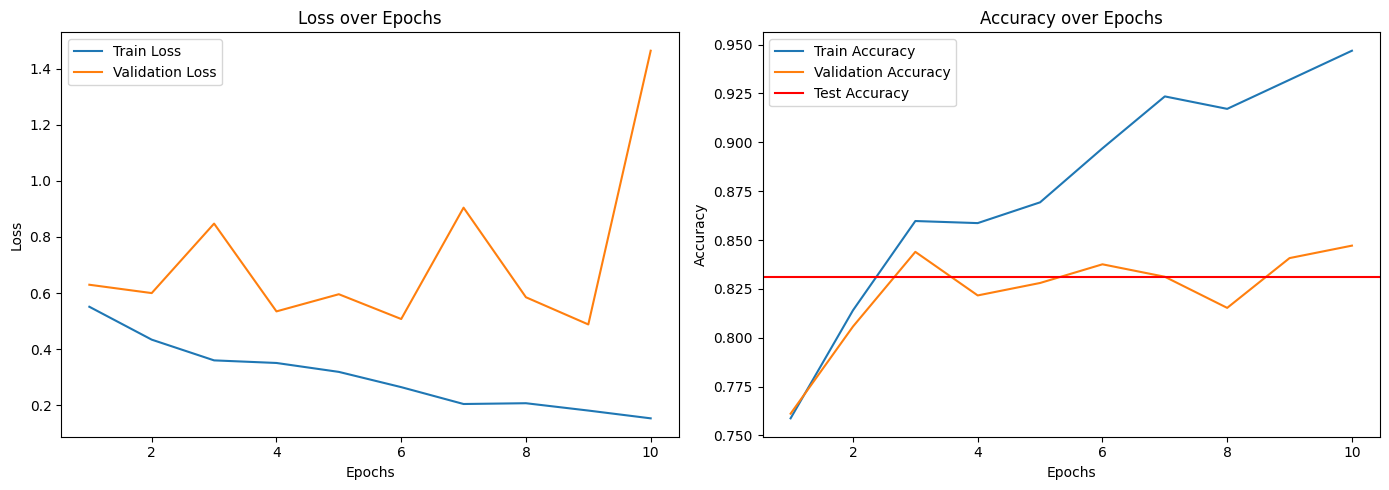

In [ ]:
# 1. Dataset personalizado

import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import itertools
import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

def preprocess_metadata(metadata):
    numeric_cols = ['locationLon', 'locationLat', 'xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks']
    categorical_cols = ['categories']
    text_cols = ['name', 'shortDescription']

    for col in numeric_cols + categorical_cols + text_cols:
        if col not in metadata.columns:
            raise ValueError(f"Columna '{col}' no encontrada en el dataframe.")

    scaler = RobustScaler()
    numeric_scaled = scaler.fit_transform(metadata[numeric_cols])

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    categorical_encoded = encoder.fit_transform(metadata[categorical_cols])

    tfidf = TfidfVectorizer(max_features=50, ngram_range=(1, 2))
    text_data = metadata[text_cols].fillna('').apply(lambda x: ' '.join(x.astype(str)), axis=1)
    text_encoded = tfidf.fit_transform(text_data).toarray()

    mlb = MultiLabelBinarizer()
    tags_encoded = mlb.fit_transform(metadata['tags'])

    metadata_processed = np.hstack([numeric_scaled, categorical_encoded, text_encoded, tags_encoded])

    return metadata_processed

class POIDataset(Dataset):
    def __init__(self, image_paths, metadata, labels, transform=None):
        self.image_paths = image_paths
        self.metadata = metadata
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        metadata = torch.tensor(self.metadata[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, metadata, label

class HybridModel(nn.Module):
    def __init__(self, metadata_input_size, dropout_rate=0.5, num_layers=2, neurons=[128, 64], freeze_image_model=False):
        super(HybridModel, self).__init__()
        self.image_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        image_features_dim = self.image_model.classifier[1].in_features  # Get in_features before replacing

        self.image_model.classifier = nn.Identity()  # Removemos la última capa de clasificación

        if freeze_image_model:
            for param in self.image_model.parameters():
                param.requires_grad = False

        self.metadata_layers = nn.ModuleList()
        input_dim = metadata_input_size

        for n in neurons:
            self.metadata_layers.append(nn.Linear(input_dim, n))
            self.metadata_layers.append(nn.ReLU())
            self.metadata_layers.append(nn.Dropout(dropout_rate))
            input_dim = n

        self.metadata_network = nn.Sequential(*self.metadata_layers)
        combined_input_size = image_features_dim + neurons[-1]
        self.fc_out = nn.Sequential(
            nn.Linear(combined_input_size, 1),
            nn.Sigmoid()
        )

    def forward(self, images, metadata):
        img_features = self.image_model(images)
        metadata_features = self.metadata_network(metadata)
        combined_features = torch.cat((img_features, metadata_features), dim=1)
        output = self.fc_out(combined_features)
        return output

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        for images, metadata, labels in train_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, metadata).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            correct_train += ((outputs > 0.5).int() == labels.int()).sum().item()
            total_train += labels.size(0)

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss / total_train)

        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, metadata, labels in val_loader:
                images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
                outputs = model(images, metadata).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                correct_val += ((outputs > 0.5).int() == labels.int()).sum().item()
                total_val += labels.size(0)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss / total_val)
        print(f"Epoch {epoch+1}/{epochs} - Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_accuracies, val_accuracies, train_losses, val_losses

def evaluate_model(model, data_loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, metadata, labels in data_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata).squeeze()

            # Asegurarse de que outputs tenga la forma correcta
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)

    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "auc": auc,
        "confusion_matrix": cm,
        "sensitivity": sensitivity,
        "specificity": specificity
    }

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='-', label='Test Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 5. Pipeline principal
image_dir = 'data_main'
data_path = 'poi_dataset.csv'
threshold = 50
metadata = pd.read_csv(data_path)
image_paths, labels = [], []

for _, row in metadata.iterrows():
    image_path = row['main_image_path']
    if os.path.exists(image_path):
        image_paths.append(image_path)
        labels.append(1 if row['Likes'] - row['Dislikes'] > threshold else 0)

metadata_processed = preprocess_metadata(metadata)
train_paths, test_paths, train_metadata, test_metadata, train_labels, test_labels = train_test_split(
    image_paths, metadata_processed, labels, test_size=0.2, random_state=42
)
train_paths, val_paths, train_metadata, val_metadata, train_labels, val_labels = train_test_split(
    train_paths, train_metadata, train_labels, test_size=0.25, random_state=42
)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

common_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = POIDataset(train_paths, train_metadata, train_labels, transform=train_transform)
val_dataset = POIDataset(val_paths, val_metadata, val_labels, transform=common_transform)
test_dataset = POIDataset(test_paths, test_metadata, test_labels, transform=common_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridModel(metadata_input_size=metadata_processed.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_accuracies, val_accuracies, train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)

model.eval()
test_loss, correct_test, total_test = 0.0, 0, 0
with torch.no_grad():
    for images, metadata, labels in test_loader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
        outputs = model(images, metadata).squeeze()
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        correct_test += ((outputs > 0.5).int() == labels.int()).sum().item()
        total_test += labels.size(0)

test_accuracy = correct_test / total_test
metrics = evaluate_model(model, test_loader, device)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")
print(f"AUC: {metrics['auc']:.4f}")
print(f"Sensitivity: {metrics['sensitivity']:.4f}")
print(f"Specificity: {metrics['specificity']:.4f}")
print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy)

Conclusión:

Observaciones y sugerencias para mejorar el rendimiento del modelo:

- Balance de Clases: La matriz de confusión muestra un problema de desequilibrio de clases. Puedes intentar técnicas como el sobremuestreo de la clase minoritaria o el submuestreo de la clase mayoritaria.

- Ajuste de Hiperparámetros: Podrías explorar la optimización de hiperparámetros utilizando algoritmos como Optuna, que ya importaste pero no utilizaste en el código.

- Regularización: Aumentar la regularización (Dropout, L1/L2) podría ayudar a mejorar la especificidad del modelo.

- Aumentación de Datos: Aumentar la variabilidad de las imágenes puede ayudar a mejorar la robustez del modelo.

- Ajuste del Umbral: Ajustar el umbral de decisión (actualmente 0.5) podría mejorar la precisión y la especificidad.

In [ ]:
#Modelo con Cross-Validation
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import os

# Definir las transformaciones
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

common_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cargar y preprocesar los datos
data_path = 'poi_dataset.csv'
metadata = pd.read_csv(data_path)
image_paths = metadata['main_image_path'].tolist()
labels = (metadata['Likes'] - metadata['Dislikes'] > 50).astype(int).tolist()
metadata_processed = preprocess_metadata(metadata)

# Configuración para cross-validation
kf = KFold(n_splits=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_train_accuracies = []
all_val_accuracies = []

for train_index, val_index in kf.split(image_paths):
    train_paths = [image_paths[i] for i in train_index]
    val_paths = [image_paths[i] for i in val_index]
    train_metadata = metadata_processed[train_index]
    val_metadata = metadata_processed[val_index]
    train_labels = [labels[i] for i in train_index]
    val_labels = [labels[i] for i in val_index]

    # Crear datasets y dataloaders
    train_dataset = POIDataset(train_paths, train_metadata, train_labels, transform=train_transform)
    val_dataset = POIDataset(val_paths, val_metadata, val_labels, transform=common_transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Configurar el modelo, criterio y optimizador
    model = HybridModel(metadata_input_size=metadata_processed.shape[1]).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Entrenar y evaluar
    train_accuracies, val_accuracies, train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

# Promediar los resultados de todas las particiones
mean_train_accuracy = np.mean([np.mean(acc) for acc in all_train_accuracies])
mean_val_accuracy = np.mean([np.mean(acc) for acc in all_val_accuracies])

print(f"Mean Train Accuracy: {mean_train_accuracy:.4f}")
print(f"Mean Validation Accuracy: {mean_val_accuracy:.4f}")

### Descripción de la Optimización con Optuna

El siguiente código utiliza Optuna para optimizar los hiperparámetros de un modelo híbrido de aprendizaje profundo. A continuación, se describe cada sección del código y la razón detrás de la elección de los parámetros.

##Función de Entrenamiento por Época
La función train_one_epoch entrena el modelo durante una época y calcula las métricas de rendimiento tanto para el conjunto de entrenamiento como el de validación.



##Función Objetivo para Optuna
La función objective define la búsqueda de hiperparámetros. Incluye la selección de la arquitectura del modelo, la congelación de capas, la configuración de los hiperparámetros del modelo híbrido, la elección del optimizador, y el entrenamiento y evaluación del modelo.

##Evaluación del Modelo
La función evaluate_model evalúa el modelo y calcula métricas avanzadas como precisión, recall, F1, AUC, sensibilidad y especificidad.

##Optimización con Optuna
La función optimize_hyperparameters realiza la optimización de hiperparámetros utilizando Optuna con un número especificado de pruebas (n_trials).



##Ejecución de la Optimización
Finalmente, se ejecuta la optimización y se visualizan los resultados.

### Razón de la Elección de Parámetros

- **Arquitectura del Modelo de Imagen**: Se eligen varias arquitecturas (`efficientnet_b0`, `resnet18`, `inception_v3`, `vit_b_16`) para explorar cuál ofrece el mejor rendimiento.
- **Congelación de Capas**: Congelar diferentes cantidades de capas (`0, 5, 10`) permite encontrar un equilibrio entre velocidad de entrenamiento y capacidad de aprendizaje.
- **Hiperparámetros del Modelo Híbrido**:
  - `neurons`: Número de neuronas en las capas ocultas, variando entre 32 y 256.
  - `dropout_rate`: Tasa de dropout para prevenir el sobreajuste, variando entre 0.1 y 0.6.
  - `bias`: Si se utiliza bias en las capas.
- **Optimización**: Se prueban diferentes optimizadores (`Adam`, `SGD`, `AdamW`) con sus respectivos parámetros (`lr`, `weight_decay`, `momentum`).
- **Scheduler**: Se utiliza `ReduceLROnPlateau` para ajustar la tasa de aprendizaje basado en la pérdida de validación.

La combinación de estos parámetros permite un ajuste fino del modelo para maximizar el rendimiento en términos de métricas como AUC.

In [ ]:
import optuna
import pandas as pd
import time
from torchvision.models import resnet18, inception_v3, vit_b_16
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau


def train_one_epoch(model, train_loader, val_loader, criterion, optimizer, scheduler, device):
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    for images, metadata, labels in train_loader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, metadata).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        correct_train += ((outputs > 0.5).int() == labels.int()).sum().item()
        total_train += labels.size(0)

    train_auc = roc_auc_score(labels.cpu().numpy(), outputs.detach().cpu().numpy())

    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, metadata, labels in val_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata).squeeze()
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            correct_val += ((outputs > 0.5).int() == labels.int()).sum().item()
            total_val += labels.size(0)

    val_auc = roc_auc_score(labels.cpu().numpy(), outputs.detach().cpu().numpy())

    # Update the scheduler with the validation loss
    scheduler.step(val_loss / total_val)

    return train_auc, val_auc
# Función objetivo para Optuna
def objective(trial, train_loader, val_loader, test_loader, device, metadata_size):
    """
    Función objetivo para búsqueda de hiperparámetros con Optuna.
    """
    # Selección de arquitectura de imagen
    architecture = trial.suggest_categorical("architecture", ["efficientnet_b0", "resnet18", "inception_v3", "vit_b_16"])
    if architecture == "efficientnet_b0":
        image_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    elif architecture == "resnet18":
        image_model = resnet18(weights=models.ResNet18_Weights.DEFAULT)
    elif architecture == "inception_v3":
        image_model = inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
    elif architecture == "vit_b_16":
        image_model = vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

    # Congelar capas
    freeze_layers = trial.suggest_categorical("freeze_layers", [0, 5, 10])
    for i, param in enumerate(image_model.parameters()):
        param.requires_grad = i >= freeze_layers

    # Hiperparámetros del modelo híbrido
    neurons = [trial.suggest_int(f"neurons_{i}", 32, 256, step=32) for i in range(2)]
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.6, step=0.1)
    bias = trial.suggest_categorical("bias", [True, False])

    # Crear modelo
    model = HybridModel(
        metadata_input_size=metadata_size,
        dropout_rate=dropout_rate,
        neurons=neurons,
        freeze_image_model=False
    ).to(device)

    # Selección de optimizador
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0, 1e-3, step=1e-4)
    momentum = trial.suggest_float("momentum", 0.5, 0.9) if optimizer_name == "SGD" else None

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Configurar criterio y scheduler
    criterion = nn.BCELoss()
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.1)

    # Entrenamiento y evaluación
    epochs = trial.suggest_int("epochs", 5, 20)
    best_val_auc = 0
    for epoch in range(epochs):
        train_auc, val_auc = train_one_epoch(
            model, train_loader, val_loader, criterion, optimizer, scheduler, device
        )
        trial.report(val_auc, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        best_val_auc = max(best_val_auc, val_auc)

    # Evaluación en test y métricas avanzadas
    start_time = time.time()
    metrics = evaluate_model(model, test_loader, device)
    inference_time = time.time() - start_time

    # Reportar métricas adicionales
    print(f"Inference Time: {inference_time:.4f} seconds")
    print(f"Sensitivity: {metrics['sensitivity']:.4f}, Specificity: {metrics['specificity']:.4f}")

    return metrics["auc"]

# Evaluación de modelo extendida
def evaluate_model(model, data_loader, device):
    """
    Evalúa el modelo y calcula métricas avanzadas.
    """
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, metadata, labels in data_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata).squeeze()
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calcular métricas
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)

    # Sensibilidad y especificidad
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "auc": auc,
        "confusion_matrix": cm,
        "sensitivity": sensitivity,
        "specificity": specificity
    }

# Optimización con Optuna
def optimize_hyperparameters(train_loader, val_loader, test_loader, device, metadata_size, n_trials=50):
    study = optuna.create_study(direction="maximize", pruner=MedianPruner())
    study.optimize(
        lambda trial: objective(trial, train_loader, val_loader, test_loader, device, metadata_size),
        n_trials=n_trials
    )

    # Get the best trial
    best_trial = study.best_trial

    # Re-train the best model on the entire dataset
    model = HybridModel(
        metadata_input_size=metadata_size,
        dropout_rate=best_trial.params["dropout_rate"],
        neurons=[best_trial.params[f"neurons_{i}"] for i in range(2)],
        freeze_image_model=False
    ).to(device)

    optimizer_name = best_trial.params["optimizer"]
    lr = best_trial.params["lr"]
    weight_decay = best_trial.params["weight_decay"]
    momentum = best_trial.params.get("momentum", None)

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    criterion = nn.BCELoss()
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.1)

    # Train the model on the entire dataset
    for epoch in range(best_trial.params["epochs"]):
        train_auc, val_auc = train_one_epoch(model, train_loader, val_loader, criterion, optimizer, scheduler, device)

    # Evaluate the model on the test set
    metrics = evaluate_model(model, test_loader, device)

    # Print and return the final metrics
    print(f"Final Metrics: {metrics}")

    # Save the study results
    study_results = pd.DataFrame(study.trials_dataframe())
    study_results.to_csv("optuna_advanced_results.csv", index=False)

    print("\nBest Trial:")
    print(study.best_trial)

    return study, metrics

# Ejecutar optimización
metadata_size = metadata_processed.shape[1]
study, final_metrics = optimize_hyperparameters(train_loader, val_loader, test_loader, device, metadata_size, n_trials=50)

# Visualización
plot_optimization_history(study).show()
plot_param_importances(study).show()

# Display final metrics
print(f"Final Metrics: {final_metrics}")

[I 2025-01-23 10:02:56,214] A new study created in memory with name: no-name-330f4311-25f0-4e6c-bc5e-6635318472d1
[I 2025-01-23 10:05:28,490] Trial 0 finished with value: 0.9096500875799421 and parameters: {'architecture': 'efficientnet_b0', 'freeze_layers': 5, 'neurons_0': 256, 'neurons_1': 64, 'dropout_rate': 0.4, 'bias': False, 'optimizer': 'Adam', 'lr': 5.0425394162648476e-05, 'weight_decay': 0.0004, 'epochs': 10}. Best is trial 0 with value: 0.9096500875799421.


Inference Time: 0.8999 seconds
Sensitivity: 1.0000, Specificity: 0.0000


[I 2025-01-23 10:08:29,123] Trial 1 finished with value: 0.7768951892134098 and parameters: {'architecture': 'efficientnet_b0', 'freeze_layers': 0, 'neurons_0': 96, 'neurons_1': 256, 'dropout_rate': 0.30000000000000004, 'bias': False, 'optimizer': 'SGD', 'lr': 0.00011477023403694243, 'weight_decay': 0.0001, 'momentum': 0.8250567278013476, 'epochs': 12}. Best is trial 0 with value: 0.9096500875799421.


Inference Time: 0.9026 seconds
Sensitivity: 1.0000, Specificity: 0.0000


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 167MB/s] 
[I 2025-01-23 10:13:33,452] Trial 2 finished with value: 0.9224000977636563 and parameters: {'architecture': 'inception_v3', 'freeze_layers': 5, 'neurons_0': 128, 'neurons_1': 256, 'dropout_rate': 0.1, 'bias': False, 'optimizer': 'Adam', 'lr': 4.2497369086849343e-05, 'weight_decay': 0.0006000000000000001, 'epochs': 20}. Best is trial 2 with value: 0.9224000977636563.


Inference Time: 0.9673 seconds
Sensitivity: 1.0000, Specificity: 0.0000


[I 2025-01-23 10:14:51,047] Trial 3 finished with value: 0.7782801743451871 and parameters: {'architecture': 'vit_b_16', 'freeze_layers': 10, 'neurons_0': 128, 'neurons_1': 32, 'dropout_rate': 0.5, 'bias': True, 'optimizer': 'SGD', 'lr': 0.00035250719959094274, 'weight_decay': 0.001, 'momentum': 0.6945032386378795, 'epochs': 5}. Best is trial 2 with value: 0.9224000977636563.


Inference Time: 1.1137 seconds
Sensitivity: 1.0000, Specificity: 0.0000


[I 2025-01-23 10:17:23,765] Trial 4 finished with value: 0.8895270683123551 and parameters: {'architecture': 'vit_b_16', 'freeze_layers': 10, 'neurons_0': 224, 'neurons_1': 224, 'dropout_rate': 0.30000000000000004, 'bias': True, 'optimizer': 'Adam', 'lr': 1.0608043613914115e-05, 'weight_decay': 0.0009000000000000001, 'epochs': 10}. Best is trial 2 with value: 0.9224000977636563.


Inference Time: 0.8953 seconds
Sensitivity: 1.0000, Specificity: 0.0000


[I 2025-01-23 10:17:39,298] Trial 5 pruned. 
[I 2025-01-23 10:18:10,165] Trial 6 pruned. 
[I 2025-01-23 10:20:26,033] Trial 7 finished with value: 0.9098537618640271 and parameters: {'architecture': 'efficientnet_b0', 'freeze_layers': 5, 'neurons_0': 256, 'neurons_1': 160, 'dropout_rate': 0.5, 'bias': False, 'optimizer': 'AdamW', 'lr': 7.501161043278146e-05, 'weight_decay': 0.001, 'epochs': 9}. Best is trial 2 with value: 0.9224000977636563.


Inference Time: 1.1764 seconds
Sensitivity: 1.0000, Specificity: 0.0000


[I 2025-01-23 10:23:11,473] Trial 8 finished with value: 0.9098130270072101 and parameters: {'architecture': 'efficientnet_b0', 'freeze_layers': 5, 'neurons_0': 64, 'neurons_1': 192, 'dropout_rate': 0.30000000000000004, 'bias': False, 'optimizer': 'AdamW', 'lr': 0.00012185732482617531, 'weight_decay': 0.00030000000000000003, 'epochs': 11}. Best is trial 2 with value: 0.9224000977636563.


Inference Time: 0.9032 seconds
Sensitivity: 1.0000, Specificity: 0.0000


[I 2025-01-23 10:25:58,176] Trial 9 pruned. 
[I 2025-01-23 10:26:13,786] Trial 10 pruned. 
[I 2025-01-23 10:27:44,295] Trial 11 pruned. 
[I 2025-01-23 10:31:29,857] Trial 12 finished with value: 0.9008106236506579 and parameters: {'architecture': 'resnet18', 'freeze_layers': 5, 'neurons_0': 32, 'neurons_1': 128, 'dropout_rate': 0.6, 'bias': False, 'optimizer': 'AdamW', 'lr': 0.0010100193311972877, 'weight_decay': 0.0007, 'epochs': 15}. Best is trial 2 with value: 0.9224000977636563.


Inference Time: 0.9046 seconds
Sensitivity: 1.0000, Specificity: 0.0000


[I 2025-01-23 10:31:45,302] Trial 13 pruned. 
[I 2025-01-23 10:32:16,165] Trial 14 pruned. 
[I 2025-01-23 10:35:31,182] Trial 15 pruned. 
[I 2025-01-23 10:37:32,129] Trial 16 finished with value: 0.90981302700721 and parameters: {'architecture': 'inception_v3', 'freeze_layers': 5, 'neurons_0': 96, 'neurons_1': 96, 'dropout_rate': 0.5, 'bias': False, 'optimizer': 'AdamW', 'lr': 0.00010121833252482346, 'weight_decay': 0.0006000000000000001, 'epochs': 8}. Best is trial 2 with value: 0.9224000977636563.


Inference Time: 0.8932 seconds
Sensitivity: 1.0000, Specificity: 0.0000


[I 2025-01-23 10:42:33,187] Trial 17 finished with value: 0.9908346572161798 and parameters: {'architecture': 'resnet18', 'freeze_layers': 5, 'neurons_0': 192, 'neurons_1': 224, 'dropout_rate': 0.2, 'bias': False, 'optimizer': 'Adam', 'lr': 0.00661099062560781, 'weight_decay': 0.0002, 'epochs': 20}. Best is trial 17 with value: 0.9908346572161798.


Inference Time: 1.1811 seconds
Sensitivity: 1.0000, Specificity: 0.1257


[I 2025-01-23 10:42:48,451] Trial 18 pruned. 
[I 2025-01-23 10:43:03,759] Trial 19 pruned. 
[I 2025-01-23 10:43:19,142] Trial 20 pruned. 
[I 2025-01-23 10:46:04,246] Trial 21 pruned. 
[I 2025-01-23 10:46:34,451] Trial 22 pruned. 
[I 2025-01-23 10:46:50,259] Trial 23 pruned. 
[I 2025-01-23 10:49:41,747] Trial 24 pruned. 
[I 2025-01-23 10:50:42,358] Trial 25 pruned. 
[I 2025-01-23 10:50:57,536] Trial 26 pruned. 
[I 2025-01-23 10:51:59,065] Trial 27 pruned. 
[I 2025-01-23 10:52:14,348] Trial 28 pruned. 
[I 2025-01-23 10:52:29,633] Trial 29 pruned. 
[I 2025-01-23 10:53:30,285] Trial 30 pruned. 
[I 2025-01-23 10:56:15,398] Trial 31 finished with value: 0.9070430567436557 and parameters: {'architecture': 'efficientnet_b0', 'freeze_layers': 5, 'neurons_0': 32, 'neurons_1': 192, 'dropout_rate': 0.30000000000000004, 'bias': False, 'optimizer': 'AdamW', 'lr': 0.0001118110994838806, 'weight_decay': 0.00030000000000000003, 'epochs': 11}. Best is trial 17 with value: 0.9908346572161798.


Inference Time: 1.1488 seconds
Sensitivity: 1.0000, Specificity: 0.0000


[I 2025-01-23 10:59:02,352] Trial 32 finished with value: 0.9118090349912419 and parameters: {'architecture': 'efficientnet_b0', 'freeze_layers': 5, 'neurons_0': 96, 'neurons_1': 160, 'dropout_rate': 0.30000000000000004, 'bias': False, 'optimizer': 'AdamW', 'lr': 0.00016819614792282006, 'weight_decay': 0.0001, 'epochs': 11}. Best is trial 17 with value: 0.9908346572161798.


Inference Time: 0.9215 seconds
Sensitivity: 1.0000, Specificity: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
[I 2025-01-23 11:00:47,554] Trial 33 pruned. 
[I 2025-01-23 11:01:03,392] Trial 34 pruned. 
[I 2025-01-23 11:01:18,472] Trial 35 pruned. 
[I 2025-01-23 11:02:50,478] Trial 36 finished with value: 0.9023992830665201 and parameters: {'architecture': 'vit_b_16', 'freeze_layers': 10, 'neurons_0': 128, 'neurons_1': 32, 'dropout_rate': 0.5, 'bias': False, 'optimizer': 'AdamW', 'lr': 8.179444742965566e-05, 'weight_decay': 0.001, 'epochs': 6}. Best is trial 17 with value: 0.9908346572161798.


Inference Time: 0.8902 seconds
Sensitivity: 1.0000, Specificity: 0.0000


[I 2025-01-23 11:03:51,166] Trial 37 pruned. 
[I 2025-01-23 11:04:06,330] Trial 38 pruned. 
[I 2025-01-23 11:04:22,447] Trial 39 pruned. 


### Análisis del Resultado de la Optimización con Optuna. Ejecución 1, sin squeeze

#### Best Trial:
- **Número del Trial**: 13
- **Estado**: Complete
- **Valor de AUC**: 0.9927
- **Fecha de Inicio**: 2025-01-22 09:12:15
- **Fecha de Completado**: 2025-01-22 09:15:58

#### Parámetros:
- **Arquitectura**: inception_v3
- **Capas Congeladas**: 5
- **Neurona Capa 0**: 128
- **Neurona Capa 1**: 160
- **Tasa de Dropout**: 0.3
- **Bias**: False
- **Optimizador**: AdamW
- **Tasa de Aprendizaje (LR)**: 0.0014928324685773667
- **Decaimiento de Peso**: 0.0001
- **Épocas**: 14

#### Valores Intermedios por Época:
- Época 0: 0.9273
- Época 1: 0.9515
- Época 2: 0.9333
- Época 3: 0.9636
- Época 4: 0.9152
- Época 5: 0.9879
- Época 6: 0.9879
- Época 7: 0.9697
- Época 8: 0.9879
- Época 9: 0.9697
- Época 10: 0.9879
- Época 11: 0.9879
- Época 12: 0.9879
- Época 13: 0.9939

### Razón de la Elección de Parámetros
- **Arquitectura del Modelo de Imagen**: Se eligen varias arquitecturas (`efficientnet_b0`, `resnet18`, `inception_v3`, `vit_b_16`) para explorar cuál ofrece el mejor rendimiento.
- **Congelación de Capas**: Congelar diferentes cantidades de capas (`0, 5, 10`) permite encontrar un equilibrio entre velocidad de entrenamiento y capacidad de aprendizaje.
- **Hiperparámetros del Modelo Híbrido**:
  - `neurons`: Número de neuronas en las capas ocultas, variando entre 32 y 256.
  - `dropout_rate`: Tasa de dropout para prevenir el sobreajuste, variando entre 0.1 y 0.6.
  - `bias`: Si se utiliza bias en las capas.
- **Optimización**: Se prueban diferentes optimizadores (`Adam`, `SGD`, `AdamW`) con sus respectivos parámetros (`lr`, `weight_decay`, `momentum`).
- **Scheduler**: Se utiliza `ReduceLROnPlateau` para ajustar la tasa de aprendizaje basado en la pérdida de validación.

La combinación de estos parámetros permite un ajuste fino del modelo para maximizar el rendimiento en términos de métricas como AUC.

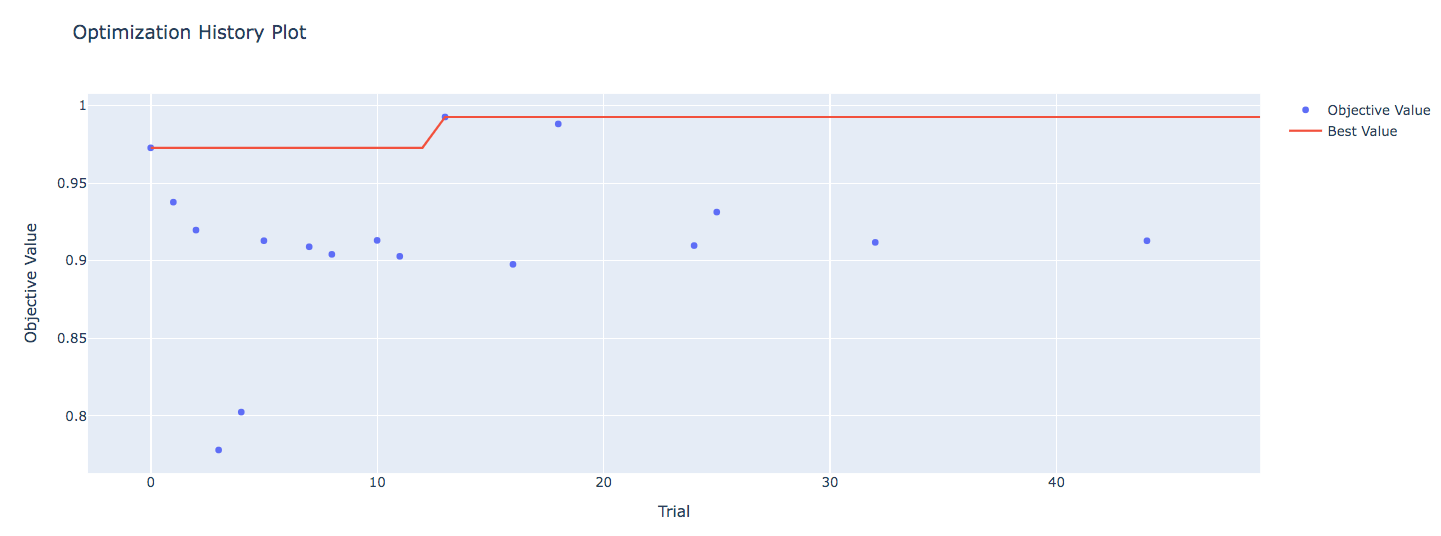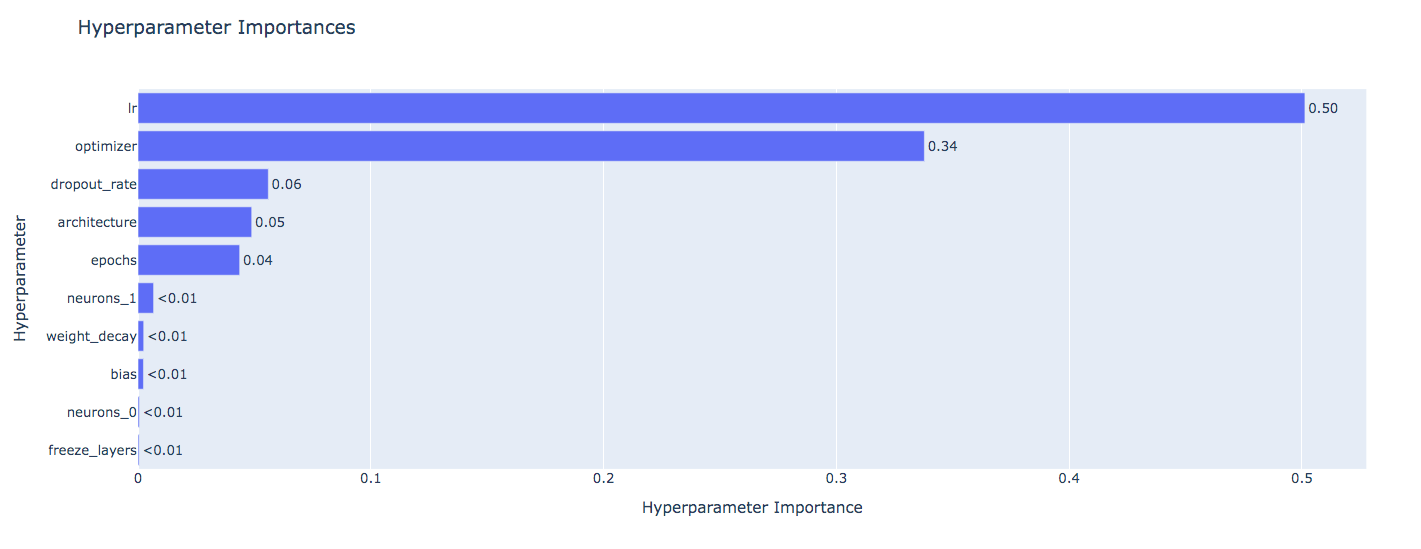

### Análisis del Resultado de la Optimización con Optuna. Ejecución 2, con squeeze.

No finaliza ejecución debido a restricciones de acceso a GPU.

El resultado muestra que el Trial 17 terminó con un valor de 0.9908346572161798 y usó los siguientes parámetros:

- Arquitectura: resnet18
- Capas congeladas: 5
- Neuronas en la primera capa oculta: 192
- Neuronas en la segunda capa oculta: 224
- Tasa de dropout: 0.2
- Bias: False
- Optimizador: Adam
- Tasa de aprendizaje (lr): 0.00661099062560781
- Decaimiento de peso (weight_decay): 0.0002
- Épocas: 20

El tiempo de inferencia fue de 1.1811 segundos. Este trial es el mejor con un valor de 0.9908346572161798.

Sensibilidad: 1.0000, Especificidad: 0.1257

Análisis: La sensibilidad de 1.0000 indica que el modelo tiene una tasa de verdaderos positivos perfecta, es decir, identifica correctamente todos los casos positivos. Sin embargo, la especificidad de 0.1257 es baja, lo que sugiere que el modelo tiene dificultades para identificar correctamente los casos negativos, resultando en una alta tasa de falsos positivos.


In [ ]:
#Análisis descriptivo de los datos de entrada

import pandas as pd

# Load the data
data_path = 'poi_dataset.csv'
metadata = pd.read_csv(data_path)

# Descriptive statistics
description = metadata.describe(include='all')

# Display the description
print(description)


                                          id  \
count                                   1569   
unique                                  1492   
top     a0f3f39c-fc87-4031-900d-d4776b1f3491   
freq                                       7   
mean                                     NaN   
std                                      NaN   
min                                      NaN   
25%                                      NaN   
50%                                      NaN   
75%                                      NaN   
max                                      NaN   

                                           name  \
count                                      1569   
unique                                     1458   
top     Ambresbury Banks en el bosque de Epping   
freq                                          7   
mean                                        NaN   
std                                         NaN   
min                                         NaN   
25%            

Descripción general:
                                            name  \
count                                      1569   
unique                                     1458   
top     Ambresbury Banks en el bosque de Epping   
freq                                          7   
mean                                        NaN   
std                                         NaN   
min                                         NaN   
25%                                         NaN   
50%                                         NaN   
75%                                         NaN   
max                                         NaN   

                                         shortDescription  \
count                                                1569   
unique                                               1491   
top     Explora Ambresbury Banks en Epping Forest, un ...   
freq                                                    7   
mean                                                  NaN   

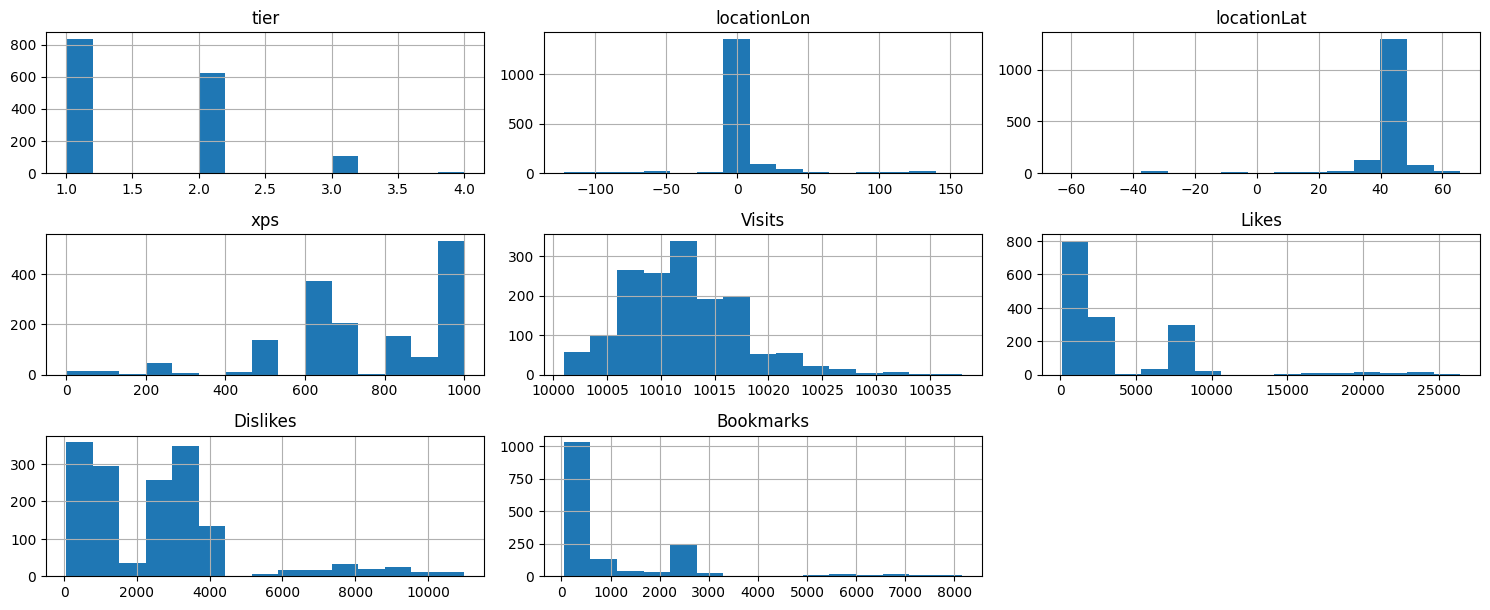

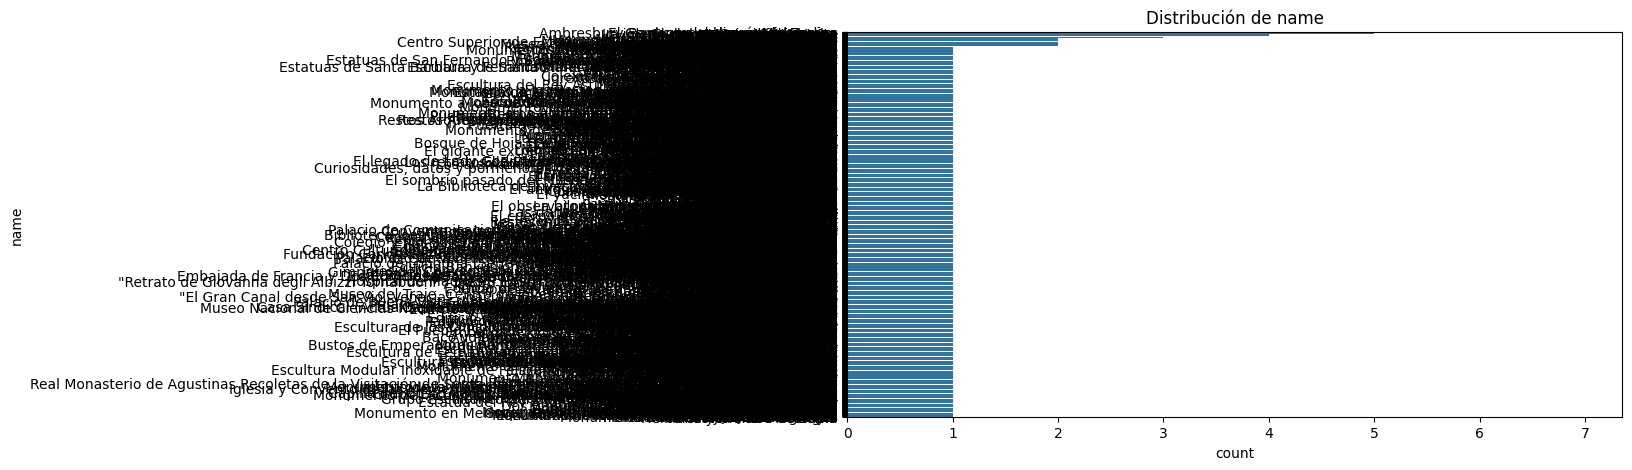

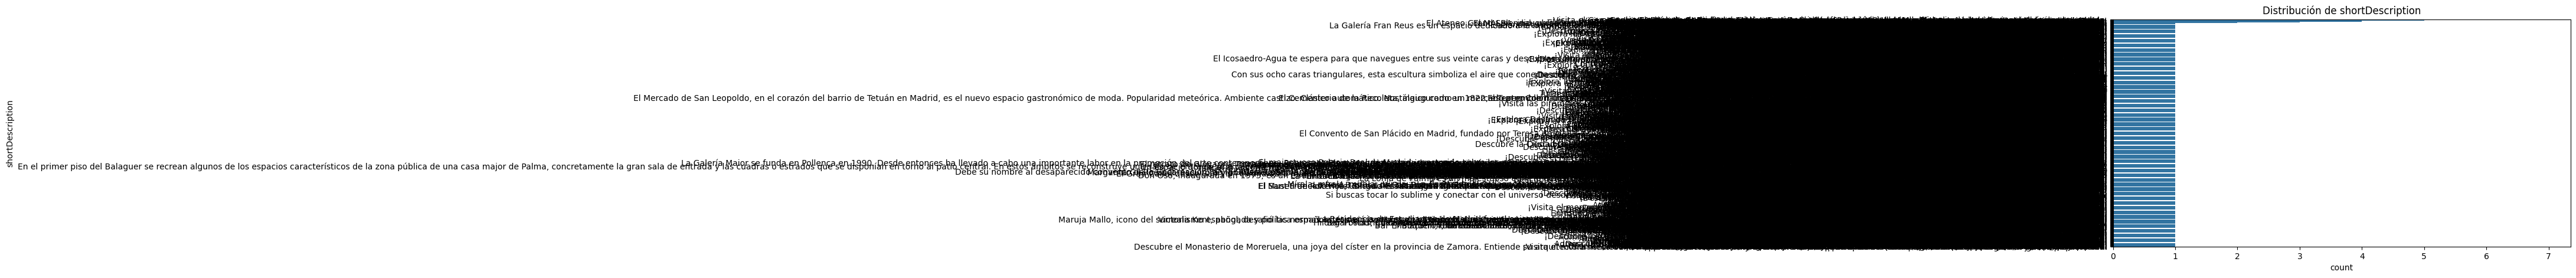

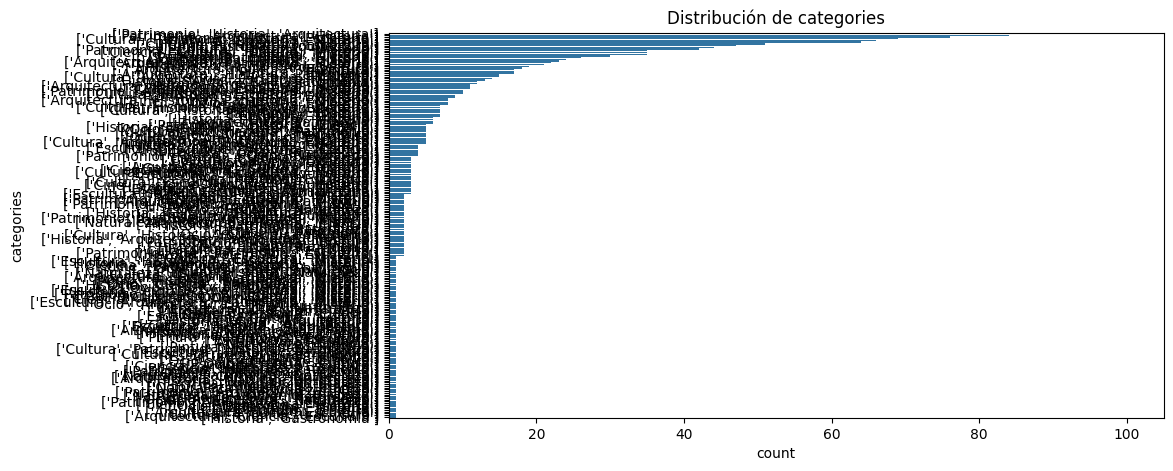

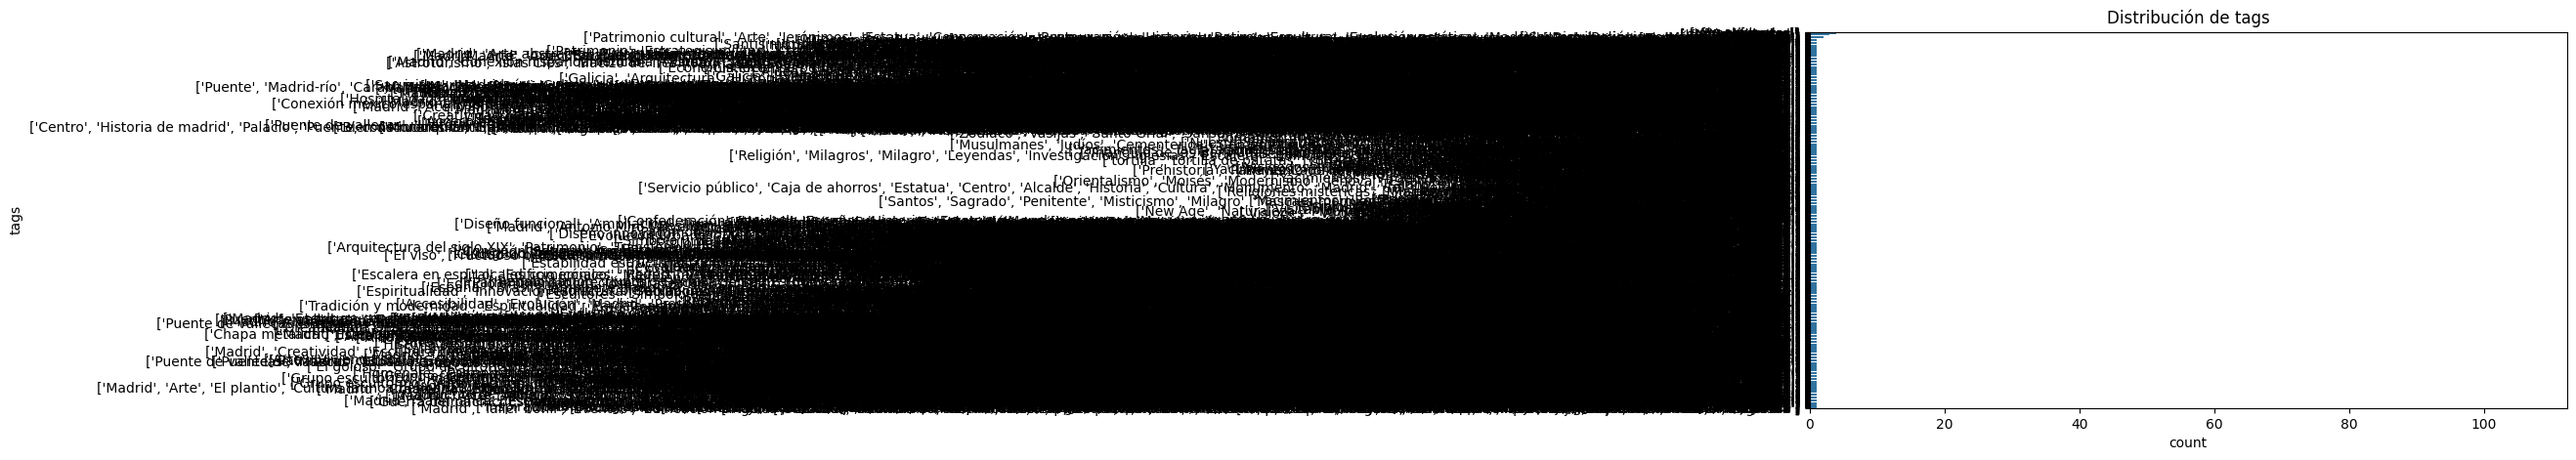

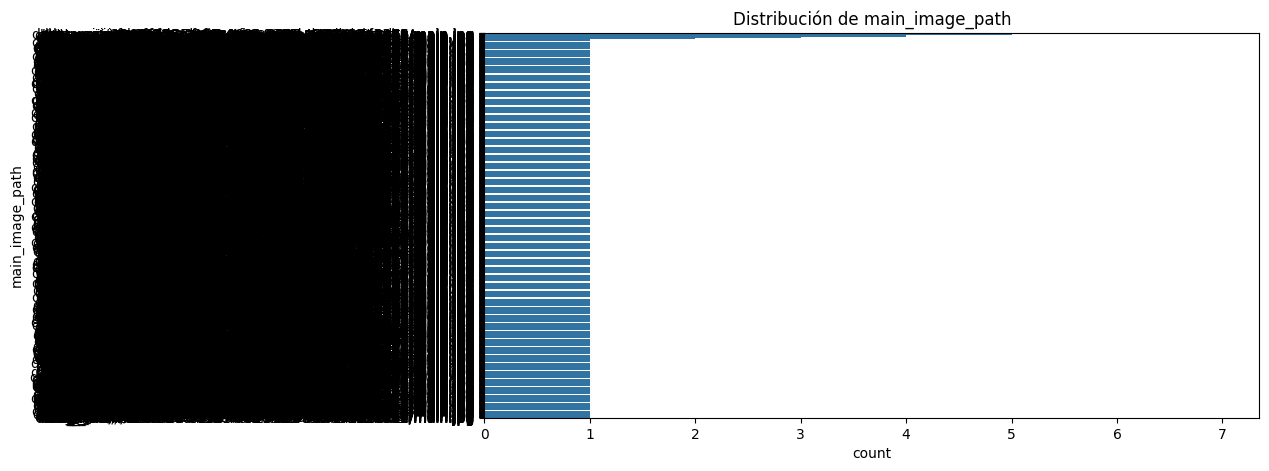

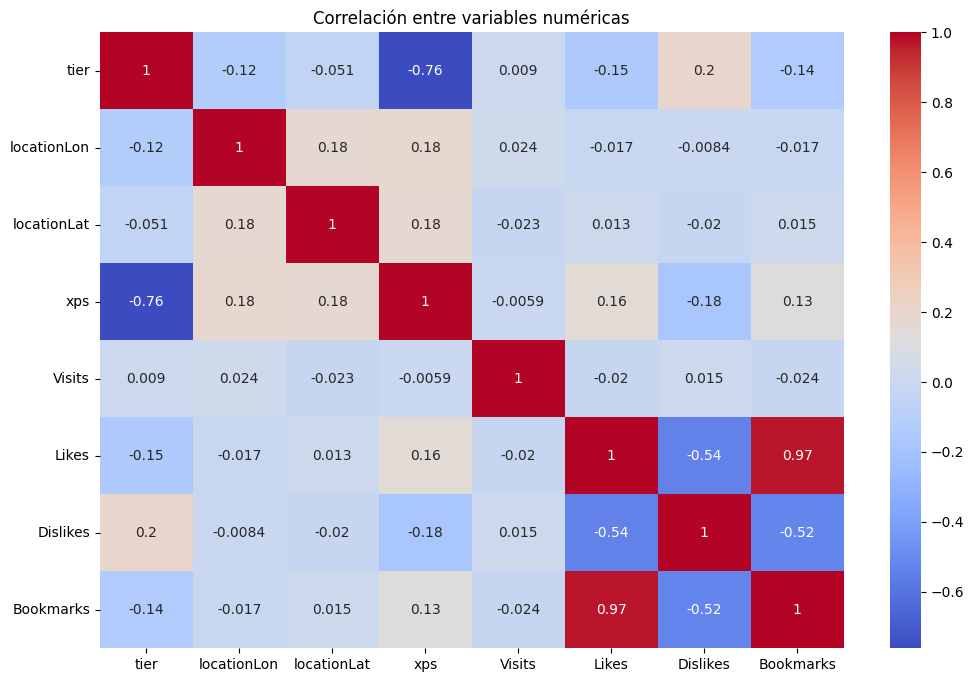

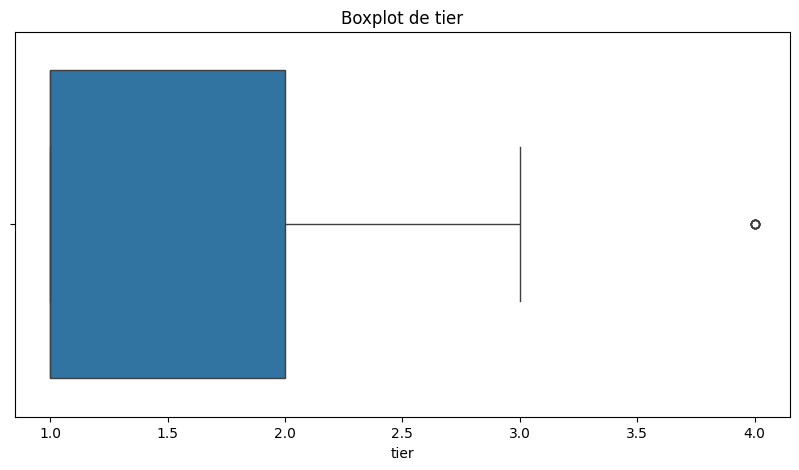

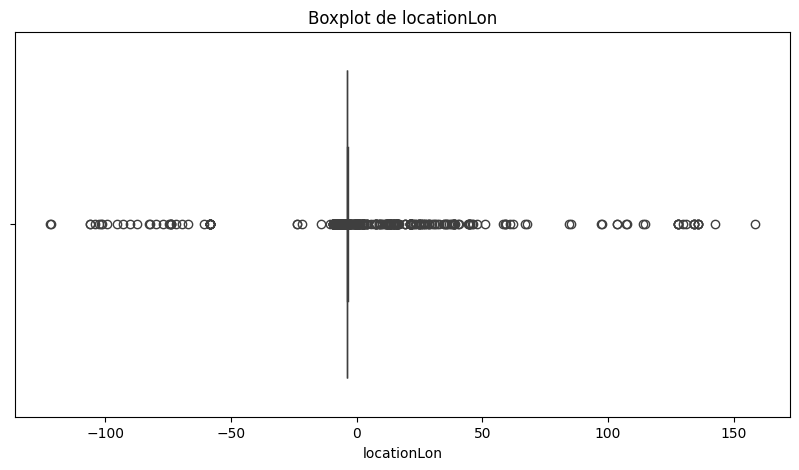

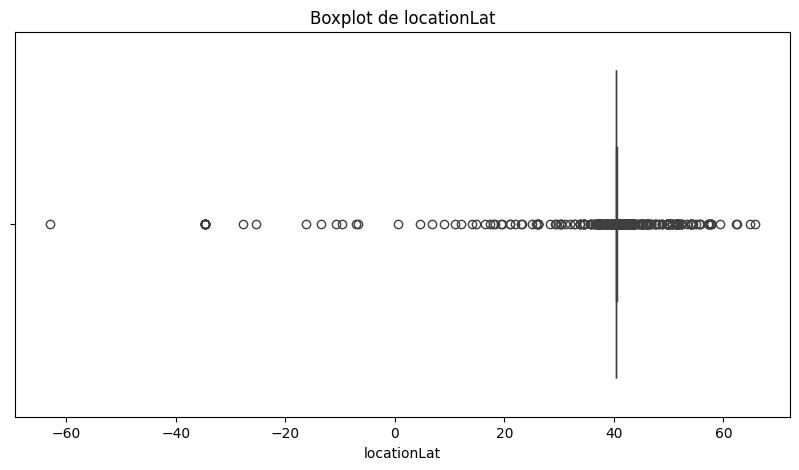

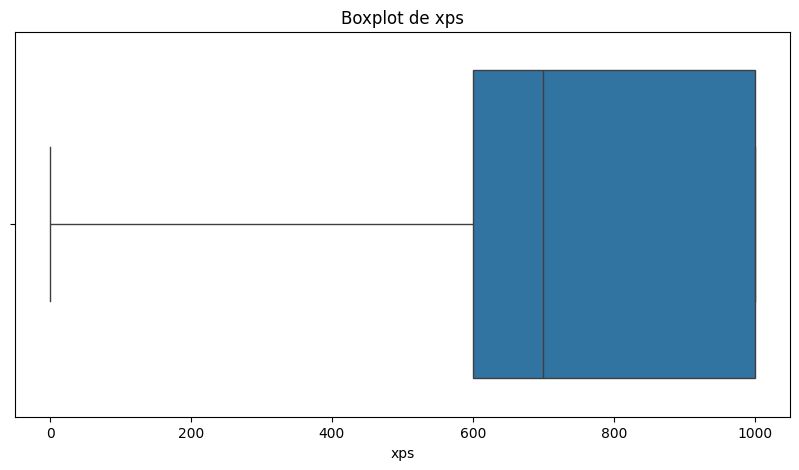

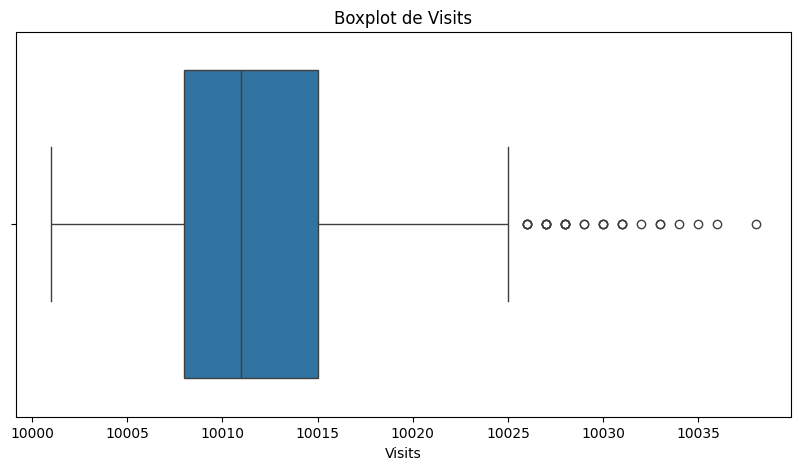

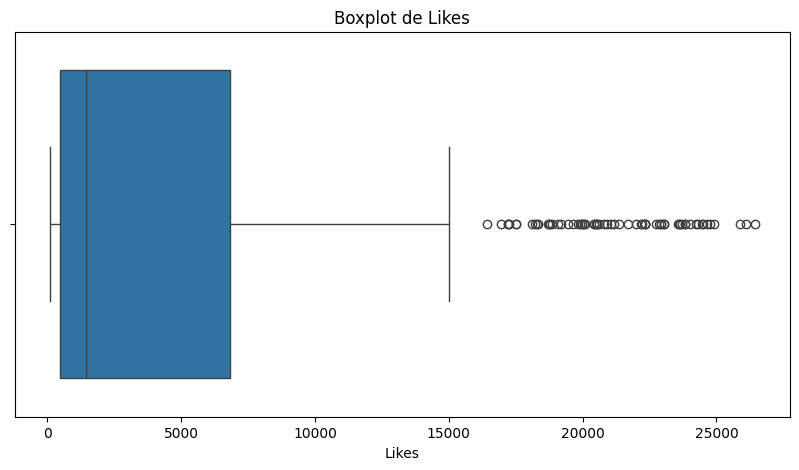

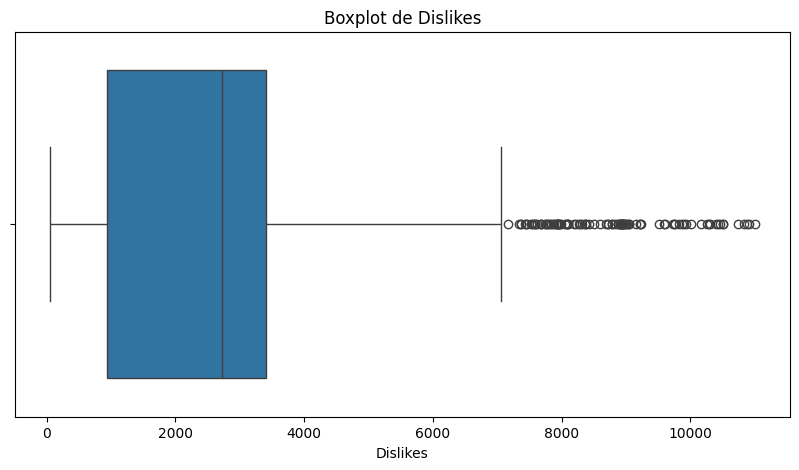

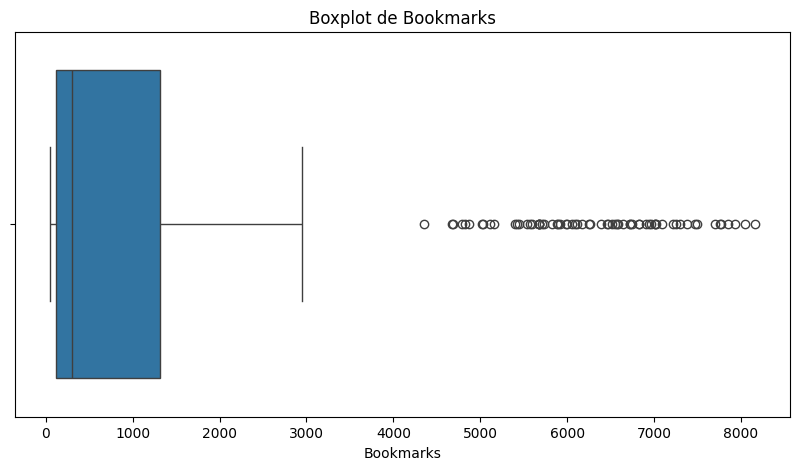

Valores únicos en name: ['Galería Fran Reus' 'Convento de San Plácido'
 'Instituto Geológico y Minero de España' ...
 'El viento se acuesta al atardecer' 'Edificio Metrópolis por Herreros'
 'Monasterio de Moreruela']
Valores únicos en shortDescription: ['La Galería Fran Reus es un espacio dedicado a la introducción de artistas emergentes y propuestas jóvenes dentro de un circuito artístico consolidado, en el ámbito nacional o internacional.'
 'El Convento de San Plácido en Madrid, fundado por Teresa de Ayala, es un enclave histórico lleno de misterio y devoción que resalta la influencia de las mujeres en la historia religiosa de la ciudad.'
 'El Instituto Geológico y Minero de España, situado en la calle de Ríos Rosas en Madrid, es un centro de investigación científica de referencia en geología.'
 ...
 'SERNY (Ricardo Summers e Isern)\nEl viento se acuesta al atardecer\nSin datos\nAcuarela, gouache y tinta sobre cartulina, 345 x 505 mm.\nPara un texto de José Luis Martín Abril\n[PLAZA 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar los datos
data_path = 'poi_dataset.csv'
metadata = pd.read_csv(data_path)

# Remover columna 'id' ya que no es relevante para el análisis numérico
metadata = metadata.drop(columns=['id'])

# Análisis descriptivo
description = metadata.describe(include='all')
print("Descripción general:\n", description)

# Mostrar las primeras filas del dataset
print("Primeras filas del dataset:\n", metadata.head())

# Verificar valores nulos
null_values = metadata.isnull().sum()
print("Valores nulos por columna:\n", null_values)

# Distribución de variables numéricas
numeric_cols = metadata.select_dtypes(include=['number']).columns
metadata[numeric_cols].hist(bins=15, figsize=(15, 10), layout=(5, 3))
plt.tight_layout()
plt.show()

# Distribución de variables categóricas
categorical_cols = metadata.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=col, data=metadata, order=metadata[col].value_counts().index)
    plt.title(f'Distribución de {col}')
    plt.show()

# Correlación entre variables numéricas
correlation = metadata[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlación entre variables numéricas')
plt.show()

# Boxplots para variables numéricas
for col in numeric_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=metadata[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

# Análisis de valores únicos para variables categóricas
for col in categorical_cols:
    unique_values = metadata[col].unique()
    print(f"Valores únicos en {col}: {unique_values}")

Hay que tener cuidado porque hay rutas de imágenes repetidas, así como con la alta correlación entre bookmark y likes. Quizás elimine bookmarks para evitar la colinealidad.

Los outliers que se aprecian en los boxplots no tienen tratamiento por lo que se dejan tal como están.

In [ ]:
#Análisis de colinealidad entre tier y xps

import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Cargar el dataset
data_path = 'poi_dataset.csv'
metadata = pd.read_csv(data_path)

# Seleccionar las columnas 'xps' y 'tier'
cols_to_check = ['xps', 'tier']
data = metadata[cols_to_check]

# Calcular VIF
vif_data = pd.DataFrame()
vif_data["feature"] = data.columns
vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

print(vif_data)

  feature       VIF
0     xps  2.770099
1    tier  2.770099


VIF por debajo de 5 se considera aceptable. Colinealidad moderada